# Fine Tuning Xception Model

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
import cv2

from sklearn.utils import shuffle

import visualize

from sklearn import svm

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.svm import LinearSVC

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import pickle

In [2]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input
import keras.backend as K
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
# load images names, create a data frame with the columns [img name, label, and path]
file_names = glob.glob('NWPU-RESISC45/*/*')
file_names_df = [i.split('/')[1:] for i in file_names]
file_names_df = pd.DataFrame(file_names_df, columns=['label','img_name'])
file_names_df['full_img_path'] = file_names

In [4]:
# load the base model
xception_model = Xception(include_top=False, weights='imagenet', input_shape=(256,256,3), pooling='max')
# load the model with no pre-trained weights. 
#this will set its weights from the above model for each time it gets re-trained.
fine_tune_xception_model = Xception(include_top=True, weights=None, input_shape=(256,256,3),classes=45)
# this model will copy the fine tuned weights each time the model above get fine tuned.
feature_extractor_xception_model = Xception(include_top=False, weights=None, input_shape=(256,256,3), pooling='max')

In [5]:
images = np.array(file_names_df['full_img_path'].apply(lambda i: cv2.imread(i)).tolist()).astype(np.float32)

In [6]:
preprocessed_imgs = xception_preprocess_input(images)
labels = np.array(file_names_df['label'])

In [7]:
num_classes = 45
batch_size = 32 
nb_epoch = 6

In [8]:
#convert labels to one-hot encoded labels
le = LabelEncoder().fit(labels)
ohe = OneHotEncoder(sparse=False).fit(le.transform(labels).reshape(len(labels),1))

one_hot_labels = ohe.transform(le.transform(labels).reshape(len(labels),1))

In [ ]:
accuracies = {}
confusion_matrices = {}

#fune tune, train and test for each train size settings for 5 times
for test_size in [.9, .8]:
    print 'test size (proportion): '+str(test_size)
    
    accuracies[str(test_size)] = []
    confusion_matrices[str(test_size)] = []
    
    splitter = ShuffleSplit(n_splits=5, test_size=test_size, random_state=0)

    for train_index, test_index in splitter.split(preprocessed_imgs):
        
        # split data for deep learning fine tuning
        X_train, y_train = preprocessed_imgs[train_index], one_hot_labels[train_index]
        
        # set the weights to the pre-trained weights
        fine_tune_xception_model.set_weights(xception_model.get_weights())
        
        # renitialize the last layer (dense layer)
        session = K.get_session()
        fine_tune_xception_model.layers[-1].kernel.initializer.run(session=session)
        
        sgd = SGD(lr=1e-3, decay=0.0005, momentum=0.9)
        fine_tune_xception_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        fine_tune_xception_model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, \
                  shuffle=True, verbose=1, validation_data=None)
        
        
        # end of fine tuning
        #########
        

        # set the weights to the fine-tuned model
        feature_extractor_xception_model.set_weights(fine_tune_xception_model.get_weights())
        
        # extract features for train and test
        X_train = feature_extractor_xception_model.predict(X_train)
        X_test = feature_extractor_xception_model.predict(preprocessed_imgs[test_index])
        
        y_train = labels[train_index]
        y_test = labels[test_index]
        
        svm = LinearSVC(random_state=0)
        svm.fit(X_train, y_train)
        
        y_hat = svm.predict(X_test)

        accuracy = accuracy_score(y_test, y_hat)
        cfnm = confusion_matrix(y_test, y_hat)
        
        accuracies[str(test_size)].append(accuracy)
        confusion_matrices[str(test_size)].append(cfnm)
                
    print np.mean(accuracies[str(test_size)])


In [11]:
print 'accuracies of Xception model'
for key in accuracies.keys():
    accuracy = np.mean(accuracies[key])
    print 'test size is '+key
    print 'accuracy for is '+str(accuracy)+' +/- '+str(np.std(accuracies[key]))

    print

accuracies of Xception model
test size is 0.9
accuracy for is 0.774765432099 +/- 0.00259613909969

test size is 0.8
accuracy for is 0.853634920635 +/- 0.000900575108096



In [12]:
classes = file_names_df['label'].unique().tolist()
classes = sorted(classes)

Normalized confusion matrix


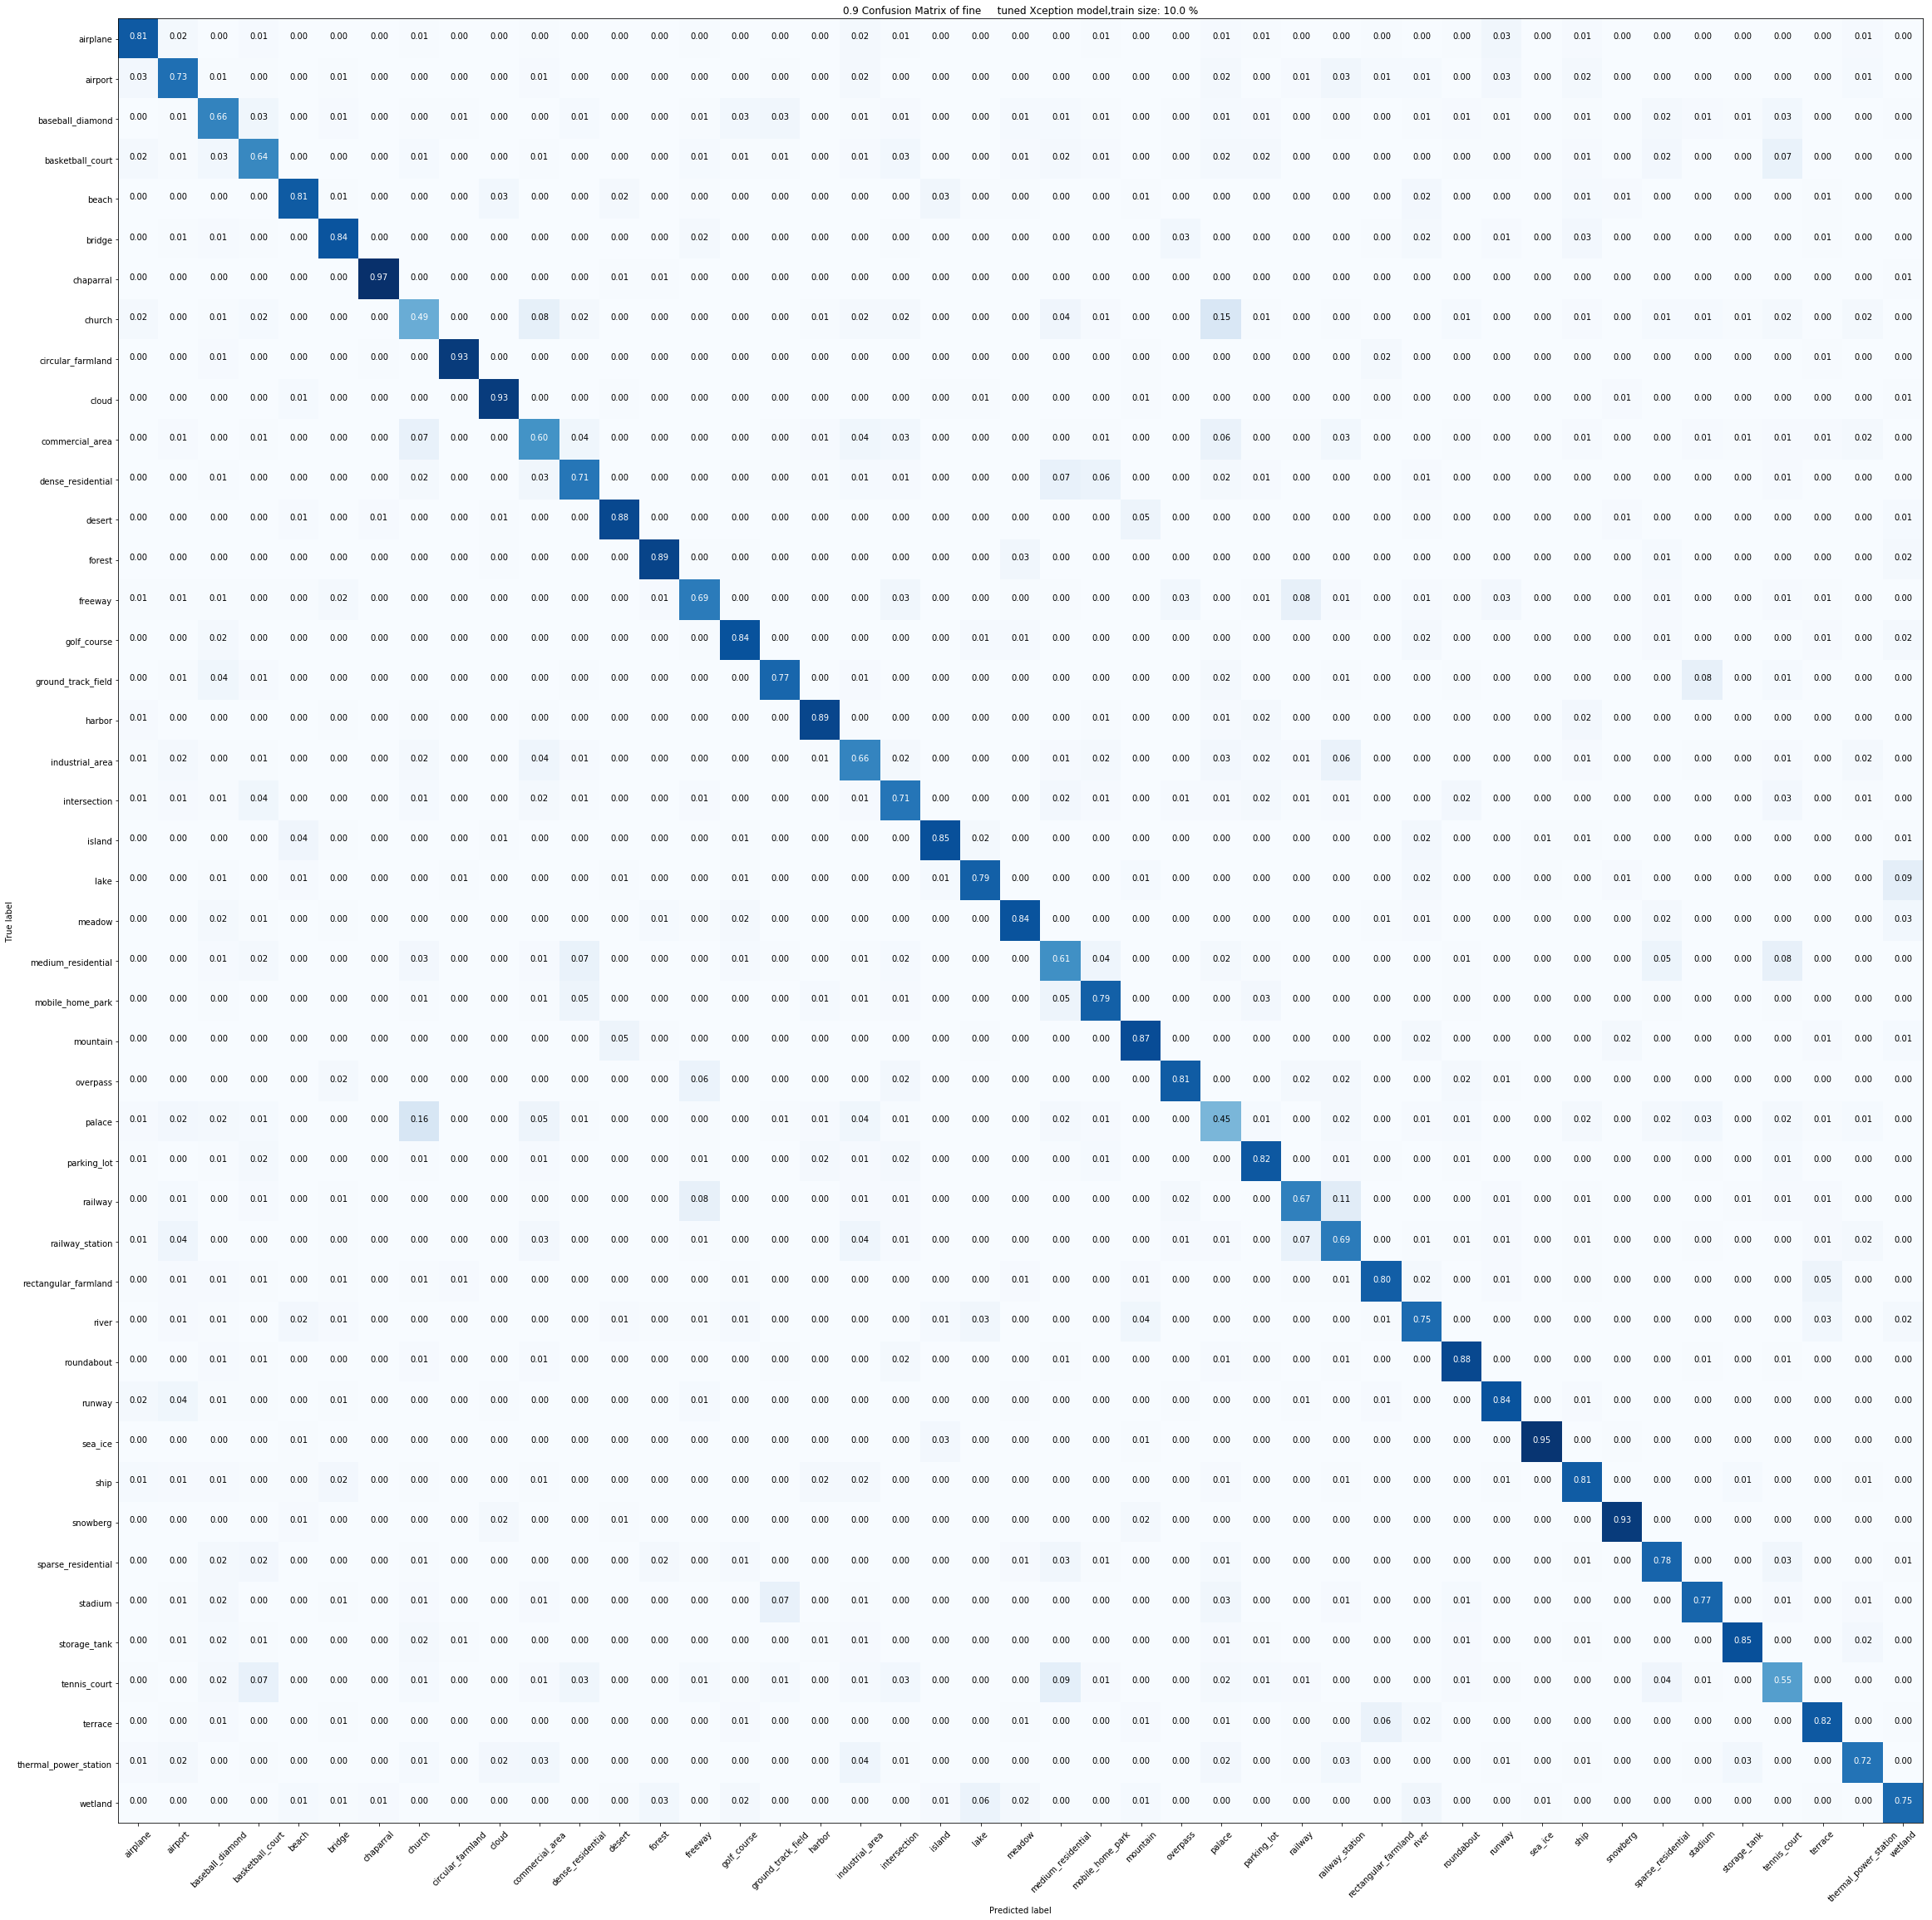

Normalized confusion matrix


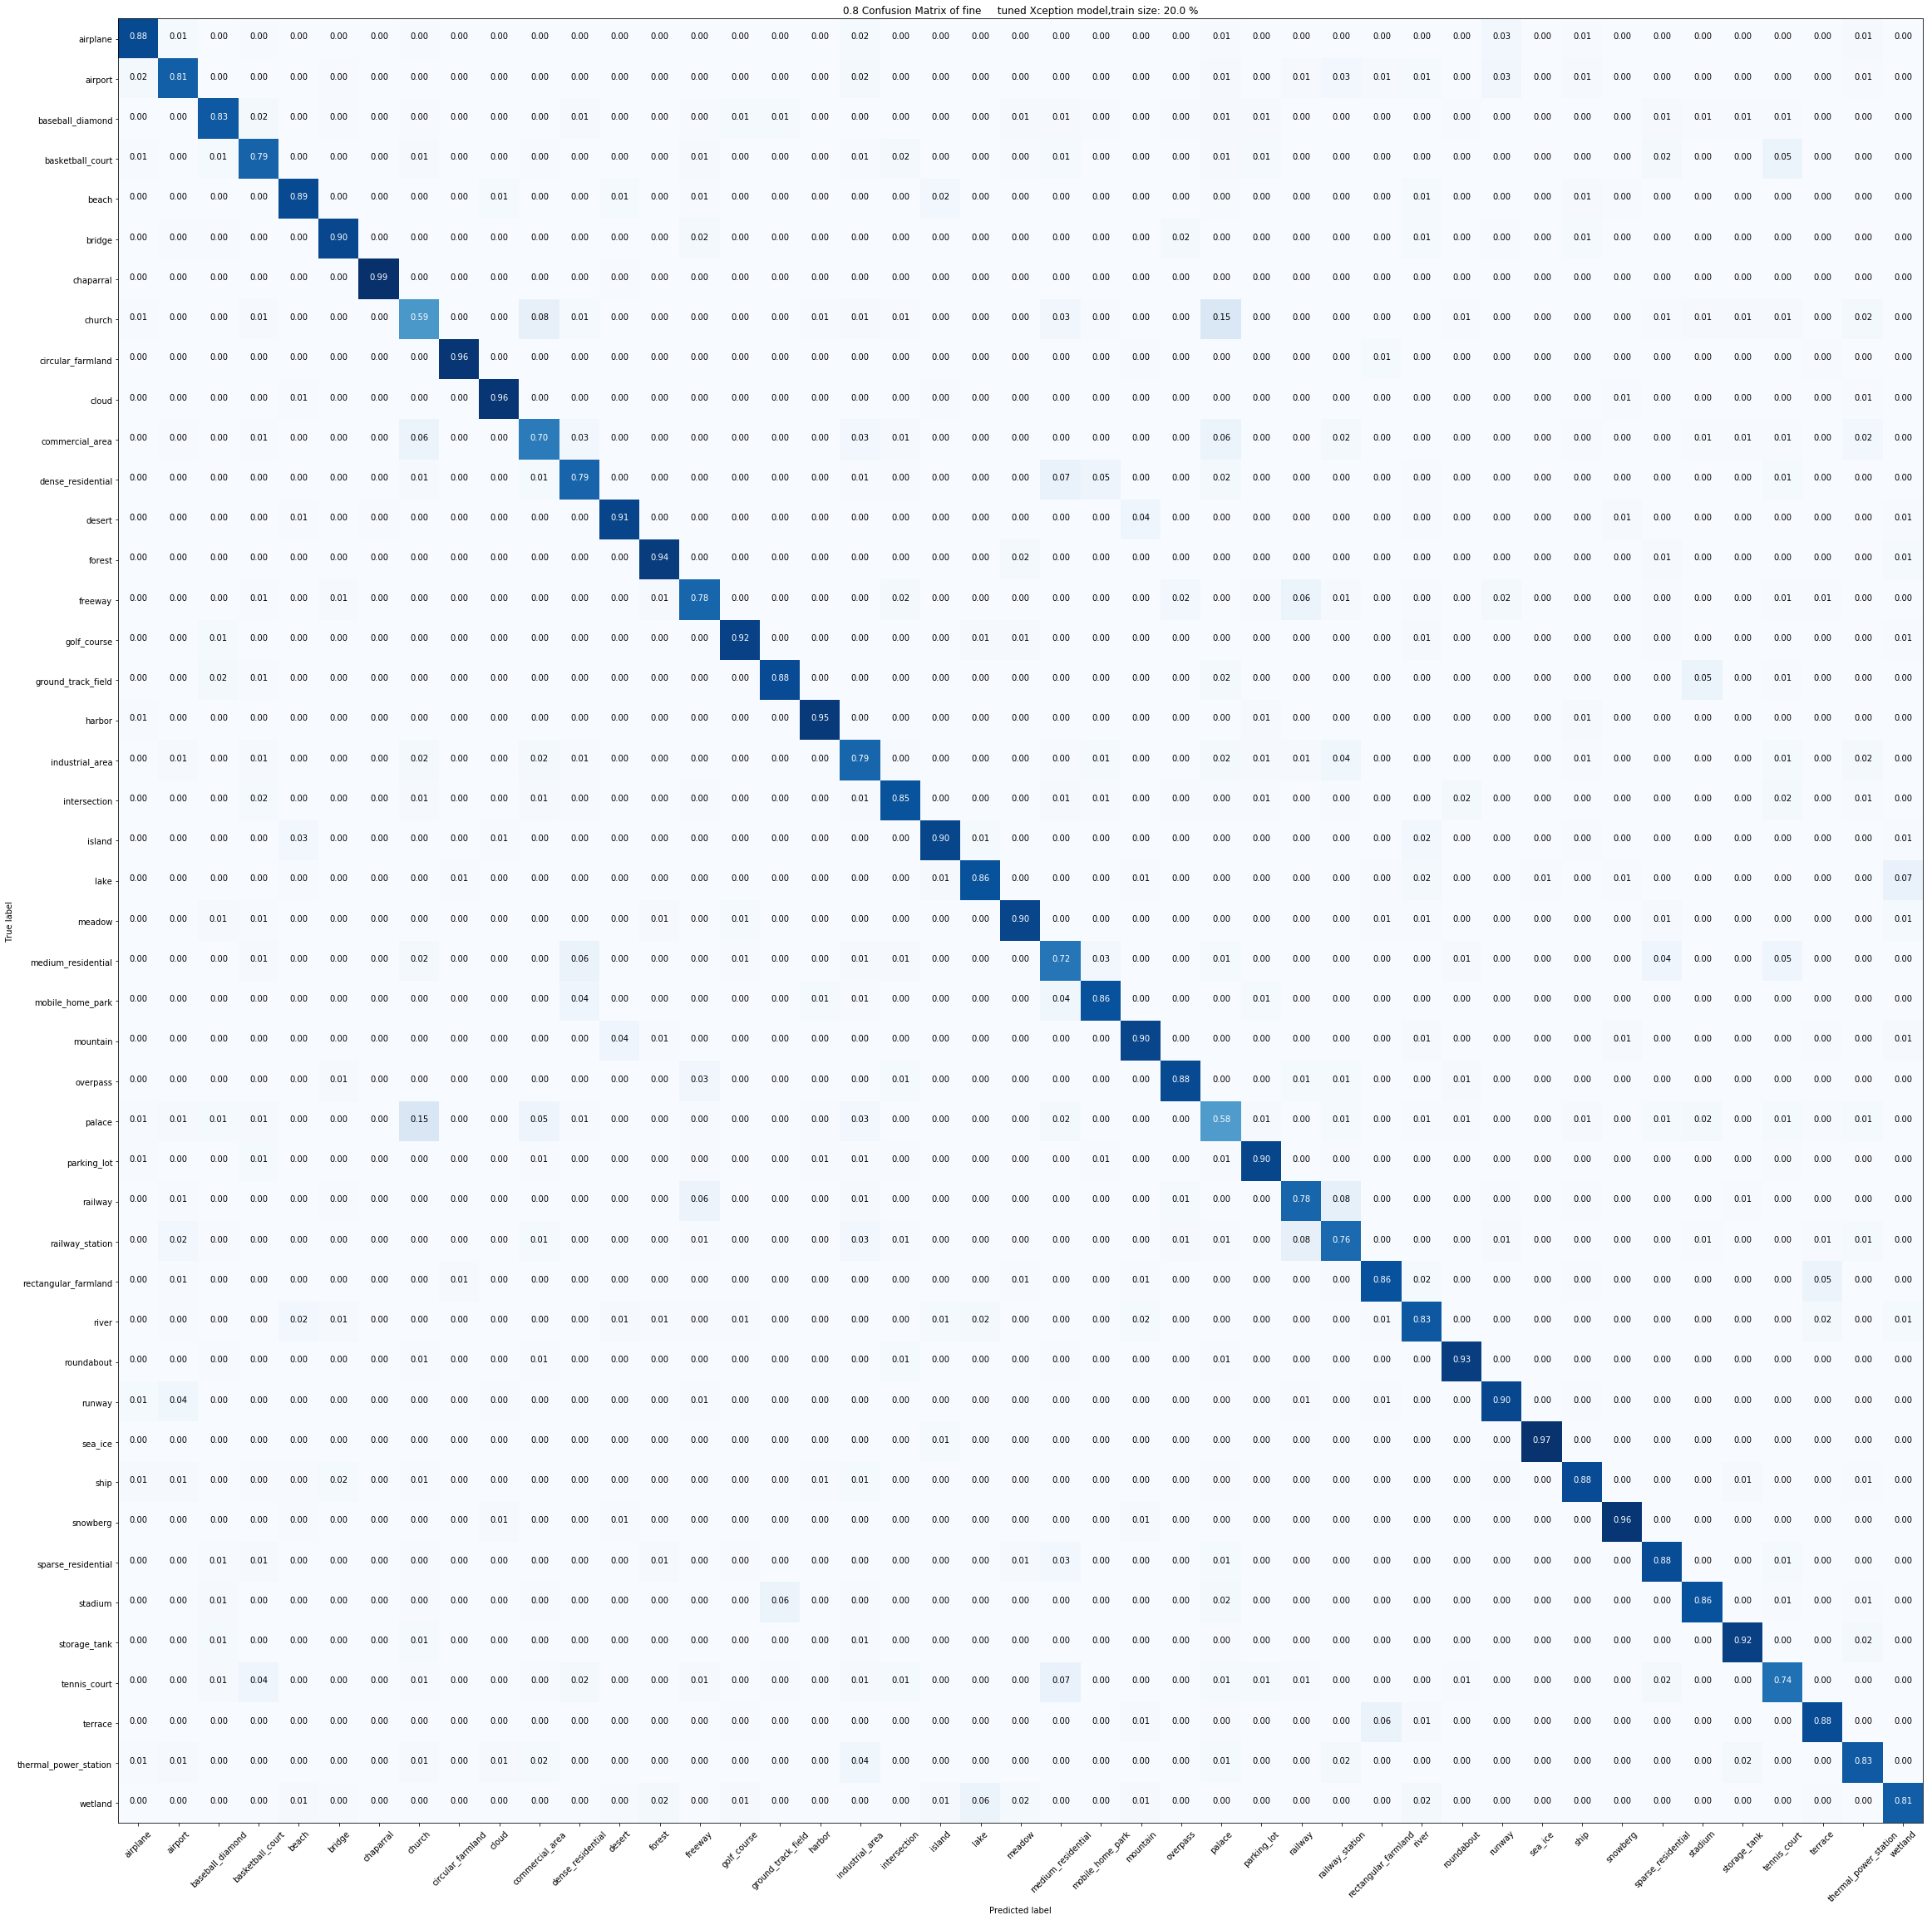

In [15]:
#plot confusion matrices
for key in confusion_matrices.keys():
    cmfn = np.sum(confusion_matrices[key], axis=0)
    visualize.plot_confusion_matrix(cmfn, classes, normalize=True, title=key+' Confusion Matrix of fine \
    tuned Xception model,'+'train size: '+str((1-float(key))*100)+ ' %')
    plt.show()